In [1]:
import pandas as pd
import numpy as np
import fastquant
import datetime
import requests
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pytrends.request import TrendReq 

In [2]:
from collections import Counter

from sklearn import svm
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
# datetime.date.today()
today = date.today().strftime("%Y-%m-%d")
y_end = int(today.split('-')[0])
m_end = int(today.split('-')[1])
d_end = int(today.split('-')[2])
today

'2022-06-04'

In [4]:
date_start = "2020-07-04"
date_end = today

In [5]:
start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
end = datetime.datetime.strptime(date_end, '%Y-%m-%d')

total_days = end - start
total_days = total_days.days
# total_days

In [6]:
BTC_1 = fastquant.get_crypto_data("BTC/USDT", date_start, date_end)
ETH_1 = fastquant.get_crypto_data("ETH/USDT", date_start, date_end)
ADA_1 = fastquant.get_crypto_data("ADA/USDT", date_start, date_end)

# Multi Index
BTC_1.columns = pd.MultiIndex.from_product([['BTC_1'], BTC_1.columns])
ETH_1.columns = pd.MultiIndex.from_product([['ETH_1'], ETH_1.columns])
ADA_1.columns = pd.MultiIndex.from_product([['ADA_1'], ADA_1.columns])

# Combine Crypto Info
price_data = pd.concat([BTC_1, ETH_1, ADA_1], axis=1)
price_data = price_data.dropna()
# price_data.head()

In [7]:
df_price = price_data.drop([
	('BTC_1', 'open'), ('BTC_1', 'high'), ('BTC_1', 'low'),
	('ETH_1', 'open'), ('ETH_1', 'high'), ('ETH_1', 'low'),
	('ADA_1', 'open'), ('ADA_1', 'high'), ('ADA_1', 'low'),
], axis=1)

df_price

BTC_1                   ETH_1                  ADA_1  \
               close         volume    close        volume    close   
dt                                                                    
2020-07-05   9069.41   34073.653627   227.56  3.557471e+05  0.09813   
2020-07-06   9344.20   54463.132277   241.60  8.648175e+05  0.10512   
2020-07-07   9257.39   34587.336678   239.39  6.004250e+05  0.11764   
2020-07-08   9436.06   56140.517781   246.95  9.581858e+05  0.12993   
2020-07-09   9232.43   48044.450645   241.98  6.476416e+05  0.12403   
...              ...            ...      ...           ...      ...   
2022-05-31  31801.04   62433.116320  1941.90  7.511034e+05  0.62680   
2022-06-01  29805.83  103395.633820  1817.95  1.037841e+06  0.55160   
2022-06-02  30452.62   56961.429280  1834.08  7.887844e+05  0.58710   
2022-06-03  29700.21   54067.447270  1775.12  7.412825e+05  0.56000   
2022-06-04  29792.41   20998.314890  1781.99  2.977978e+05  0.56060   

                          
                  volume  
dt                        
2020-07-05  3.979135e+08  
2020-07-06  4.733752e+08  
2020-07-07  7.758697e+08  
2020-07-08  1.587750e+09  
2020-07-09  8.938256e+08  
...                  ...  
2022-05-31  6.636195e+08  
2022-06-01  3.554774e+08  
2022-06-02  3.061257e+08  
2022-06-03  2.062579e+08  
2022-06-04  8.949503e+07  

[700 rows x 6 columns]

In [8]:
df_price.index = df_price.index.rename('Date')
df_price

BTC_1                   ETH_1                  ADA_1  \
               close         volume    close        volume    close   
Date                                                                  
2020-07-05   9069.41   34073.653627   227.56  3.557471e+05  0.09813   
2020-07-06   9344.20   54463.132277   241.60  8.648175e+05  0.10512   
2020-07-07   9257.39   34587.336678   239.39  6.004250e+05  0.11764   
2020-07-08   9436.06   56140.517781   246.95  9.581858e+05  0.12993   
2020-07-09   9232.43   48044.450645   241.98  6.476416e+05  0.12403   
...              ...            ...      ...           ...      ...   
2022-05-31  31801.04   62433.116320  1941.90  7.511034e+05  0.62680   
2022-06-01  29805.83  103395.633820  1817.95  1.037841e+06  0.55160   
2022-06-02  30452.62   56961.429280  1834.08  7.887844e+05  0.58710   
2022-06-03  29700.21   54067.447270  1775.12  7.412825e+05  0.56000   
2022-06-04  29792.41   20998.314890  1781.99  2.977978e+05  0.56060   

                          
                  volume  
Date                      
2020-07-05  3.979135e+08  
2020-07-06  4.733752e+08  
2020-07-07  7.758697e+08  
2020-07-08  1.587750e+09  
2020-07-09  8.938256e+08  
...                  ...  
2022-05-31  6.636195e+08  
2022-06-01  3.554774e+08  
2022-06-02  3.061257e+08  
2022-06-03  2.062579e+08  
2022-06-04  8.949503e+07  

[700 rows x 6 columns]

In [9]:
total_days

700

In [10]:
url = f"https://api.alternative.me/fng/?limit={total_days}"
response = requests.get(url)
response.raise_for_status()
data = response.json()

In [11]:
# data

In [12]:
rows = []
for i in range(total_days):
	fear_value = data['data'][i]['value']
	fear_classification = data['data'][i]['value_classification']
	t = int(data['data'][i]['timestamp'])
	t = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d')
	rows.append([t, fear_value, fear_classification])

df = pd.DataFrame(rows,columns=['Date', 'Fear_Value', "Fear_Classification"])
df.set_index("Date", inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)
df_fear = df.copy()
df_fear

,Fear_Value,Fear_Classification
Date,,
2020-07-04,38,Fear
2020-07-05,40,Fear
2020-07-06,43,Fear
2020-07-07,44,Fear
2020-07-08,44,Fear
...,...,...
2022-05-30,16,Extreme Fear
2022-05-31,17,Extreme Fear
2022-06-01,13,Extreme Fear


In [13]:
df_fear.index

DatetimeIndex(['2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07',
               '2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11',
               '2020-07-12', '2020-07-13',
               ...
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03'],
              dtype='datetime64[ns]', name='Date', length=700, freq=None)

In [14]:
df = pd.concat([df_fear, df_price], axis=1, join='inner')
df.rename(columns=''.join, inplace=True)
df.rename(columns={
"BTC_1close":"BTC_close",
"BTC_1volume":"BTC_volume",
"ETH_1close":"ETH_close",
"ETH_1volume":"ETH_volume",
"ADA_1close":"ADA_close",
"ADA_1volume":"ADA_volume",
}, inplace=True)
df

,Fear_Value,Fear_Classification,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume
Date,,,,,,,,
2020-07-05,40,Fear,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08
2020-07-06,43,Fear,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08
2020-07-07,44,Fear,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08
2020-07-08,44,Fear,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09
2020-07-09,41,Fear,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08
...,...,...,...,...,...,...,...,...
2022-05-30,16,Extreme Fear,31734.22,96785.947600,1998.78,8.149228e+05,0.56980,2.592783e+08
2022-05-31,17,Extreme Fear,31801.04,62433.116320,1941.90,7.511034e+05,0.62680,6.636195e+08
2022-06-01,13,Extreme Fear,29805.83,103395.633820,1817.95,1.037841e+06,0.55160,3.554774e+08


In [15]:
pytrend = TrendReq()
kw_list=['Bitcoin', 'Ethereum', 'Cardano']
df_hist = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=6, day_start=1, year_end=y_end, month_end=m_end, day_end=d_end, cat=0, geo='', gprop='', sleep=1, frequency='daily')

In [16]:
df_hist.index = df_hist.index.rename("Date")
df_hist.drop(["isPartial"], axis = 1, inplace=True)
df_hist

,Bitcoin,Ethereum,Cardano
Date,,,
2020-06-01,11,1,0
2020-06-02,16,2,0
2020-06-03,13,1,0
2020-06-04,12,1,0
2020-06-05,12,1,0
...,...,...,...
2022-05-29,29,6,1
2022-05-30,34,6,1
2022-05-31,35,6,2


In [17]:
dfh = df_hist.rename(columns={"Bitcoin":"BTC_searches", "Ethereum":"ETH_searches", "Cardano":"ADA_searches"})
dfh

,BTC_searches,ETH_searches,ADA_searches
Date,,,
2020-06-01,11,1,0
2020-06-02,16,2,0
2020-06-03,13,1,0
2020-06-04,12,1,0
2020-06-05,12,1,0
...,...,...,...
2022-05-29,29,6,1
2022-05-30,34,6,1
2022-05-31,35,6,2


In [18]:
# day_end

In [19]:
# df

In [20]:
df.shape

(699, 8)

In [21]:
dfh.shape

(734, 3)

In [22]:
# dfh

In [23]:
df_complete = df.join(dfh, on=df.index, how='inner')
df_complete.drop('key_0', inplace=True, axis=1)
df_complete

,Fear_Value,Fear_Classification,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,,
2020-07-05,40,Fear,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,Fear,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,Fear,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,Fear,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,Fear,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,10,Extreme Fear,29468.10,27567.347640,1813.64,4.324306e+05,0.48200,8.862653e+07,29,6,1
2022-05-30,16,Extreme Fear,31734.22,96785.947600,1998.78,8.149228e+05,0.56980,2.592783e+08,34,6,1
2022-05-31,17,Extreme Fear,31801.04,62433.116320,1941.90,7.511034e+05,0.62680,6.636195e+08,35,6,2


In [24]:
#visualise
#plot a timeseries chart
# df_hist.plot(figsize=(20, 12))
#plot seperate graphs, using theprovided keywords
# df_hist.plot(subplots=True, figsize=(20, 12));

In [25]:
df_complete['Fear_Value'] = df_complete['Fear_Value'].astype('int64')

In [26]:
df_complete.drop('Fear_Classification', inplace=True, axis=1)
df_complete

,Fear_Value,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,
2020-07-05,40,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,10,29468.10,27567.347640,1813.64,4.324306e+05,0.48200,8.862653e+07,29,6,1
2022-05-30,16,31734.22,96785.947600,1998.78,8.149228e+05,0.56980,2.592783e+08,34,6,1
2022-05-31,17,31801.04,62433.116320,1941.90,7.511034e+05,0.62680,6.636195e+08,35,6,2


In [27]:
# df_complete.dtypes

In [28]:
# df = df_complete.copy()
# df

In [29]:
# df["Fear Value"]

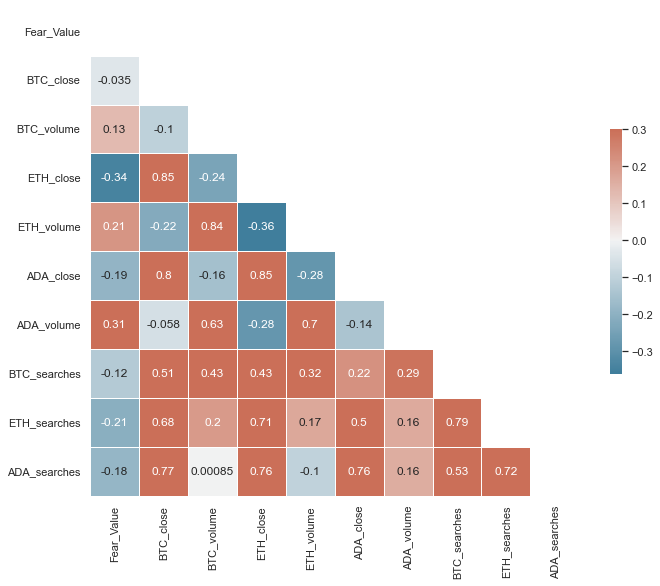

In [30]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_complete.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [31]:
# df_complete

In [32]:
# sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
# change fear_value to FG_index

In [34]:
df_complete

,Fear_Value,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,
2020-07-05,40,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,10,29468.10,27567.347640,1813.64,4.324306e+05,0.48200,8.862653e+07,29,6,1
2022-05-30,16,31734.22,96785.947600,1998.78,8.149228e+05,0.56980,2.592783e+08,34,6,1
2022-05-31,17,31801.04,62433.116320,1941.90,7.511034e+05,0.62680,6.636195e+08,35,6,2


In [35]:
# df['Fear_Value'].dtype#.mean()

fear_mean = pd.DataFrame(df_complete["Fear_Value"])
fear_mean.mean()
fear_mean.max()
fear_mean.min()
fear_mean.std()

fearful_1 = fear_mean.mean() - fear_mean.std()
greedy_1 = fear_mean.mean() + fear_mean.std()

In [36]:
fearful_1 # sell when this value is exceeded
greedy_1 # buy when below this value

Fear_Value    78.38937
dtype: float64

In [37]:
df_ada = df_complete.drop(columns=["BTC_close", "BTC_volume", "ETH_close", "ETH_volume", "BTC_searches", "ETH_searches"])

In [38]:
df_ada

,Fear_Value,ADA_close,ADA_volume,ADA_searches
Date,,,,
2020-07-05,40,0.09813,3.979135e+08,0
2020-07-06,43,0.10512,4.733752e+08,0
2020-07-07,44,0.11764,7.758697e+08,1
2020-07-08,44,0.12993,1.587750e+09,1
2020-07-09,41,0.12403,8.938256e+08,0
...,...,...,...,...
2022-05-29,10,0.48200,8.862653e+07,1
2022-05-30,16,0.56980,2.592783e+08,1
2022-05-31,17,0.62680,6.636195e+08,2


In [39]:
# df_complete[('ADA_1','close')

In [45]:
df_ada["signal"] = 0

In [55]:
 # Create the signal to buy
df_ada.loc[(df_ada["Fear_Value"] <= float(fearful_1)), "signal"] = 1
df_ada.loc[(df_ada["Fear_Value"] >= float(greedy_1)), "signal"] = -1
df_ada

,Fear_Value,ADA_close,ADA_volume,ADA_searches,signal
Date,,,,,
2020-07-05,40,0.09813,3.979135e+08,0,0
2020-07-06,43,0.10512,4.733752e+08,0,0
2020-07-07,44,0.11764,7.758697e+08,1,0
2020-07-08,44,0.12993,1.587750e+09,1,0
2020-07-09,41,0.12403,8.938256e+08,0,0
...,...,...,...,...,...
2022-05-29,10,0.48200,8.862653e+07,1,1
2022-05-30,16,0.56980,2.592783e+08,1,1
2022-05-31,17,0.62680,6.636195e+08,2,1


In [58]:
# greedy_1
# df_ada[df_ada['signal'] == -1]
# df_ada[df_ada['signal'] == 0]
# df_ada[df_ada['signal'] == 1]

,Fear_Value,ADA_close,ADA_volume,ADA_searches,signal
Date,,,,,
2020-07-05,40,0.09813,3.979135e+08,0,0
2020-07-06,43,0.10512,4.733752e+08,0,0
2020-07-07,44,0.11764,7.758697e+08,1,0
2020-07-08,44,0.12993,1.587750e+09,1,0
2020-07-09,41,0.12403,8.938256e+08,0,0
...,...,...,...,...,...
2022-04-20,27,0.93700,9.364430e+07,1,0
2022-04-25,27,0.89740,1.719445e+08,1,0
2022-05-01,28,0.78950,1.377932e+08,1,0


In [62]:
# if signal = -1
# if signal = -1

money = 1000

df_ada[df_ada['signal'] == -1]


,Fear_Value,ADA_close,ADA_volume,ADA_searches,signal
Date,,,,,
2020-08-01,80,0.14410,428476131.0,0,-1
2020-08-05,79,0.14227,247854513.3,0,-1
2020-08-08,79,0.14696,300085230.7,0,-1
2020-08-10,84,0.14383,338241373.9,0,-1
2020-08-14,79,0.13826,236113113.1,0,-1
...,...,...,...,...,...
2021-09-06,79,2.83300,186970542.2,3,-1
2021-10-16,79,2.17900,103000332.9,2,-1
2021-10-19,82,2.11000,94391775.6,3,-1


In [78]:
# ADA features
X = df_ada.drop(columns="signal")

# Create ADA target
y = df_ada["signal"]

# y = df_ada[('ETH_1','close')]

In [79]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [80]:
# df_complete

In [81]:
# X_train

In [82]:
# Create the StandardScaler instance
scaler = StandardScaler()

X_scaler = scaler.fit(X_train) # Fit the Standard Scaler with the training data

X_train_scaler = X_scaler.transform(X_train) # Scale the training and testing data
X_test_scaler = X_scaler.transform(X_test)

In [48]:
# df_ada[[df_ada['Fear_Value'] >= float(fearful_1)] = 20
# df_ada
# df_ada

In [63]:
# for i in range(len(df_ada)):
# 	if (float(df_ada["Fear_Value"][i])) <= float(fearful_1):
# 		# df_ada.iloc[i]['signal'] = 1 # buy
# 		# print(df_ada.iloc[i]['signal'])# = 1 # buy
# 		print(i)
		
# 	elif (float(df_ada["Fear_Value"][i])) >= float(greedy_1):
# 		df_ada.iloc[i]['signal'] = -1 # sell
# 	else:
# 		# print("no")
# 		df_ada.iloc[i]['signal'] = 0

In [64]:
# float(fearful_1)

In [65]:
# df_ada.loc[df_ada["Fear_Value"]]

In [66]:
# Create the signal to sell
# df_ada.loc[(df_ada["Fear_Value"] < float(greedy_1)), "signal"] = -1
# df_ada

In [ ]:
# float(fearful_1)
# float(greedy_1)

In [67]:
# df_ada

In [68]:
#  # Create a new column in the trading_df called signal setting its value to zero.
# # df_ada["signal"] = 0.0

# # Create the signal to buy
# df_ada.loc[(df_ada["Fear_Value"] <= fearful_1), "signal"] = 1

# for i in range(len(df_ada)):
# 	if (float(df_ada["Fear_Value"][i])) <= float(fearful_1):
# 		# df_ada.iloc[i]['signal'] = 1 # buy
# 		# print(df_ada.iloc[i]['signal'])# = 1 # buy
# 		print(i)
		
# 	elif (float(df_ada["Fear_Value"][i])) >= float(greedy_1):
# 		df_ada.iloc[i]['signal'] = -1 # sell
# 	else:
# 		# print("no")
# 		df_ada.iloc[i]['signal'] = 0


# # Create the signal to sell
# df_ada.loc[(df_ada["Fear_value"] >= greedy_1), "signal"] = -1

# Copy the new signal column to a new Series called y.
# y = df_ada["signal"].copy()
# 		df_ada.iloc[i]['signal'] = 1 # buy
# # y
# df_ada.min()

In [69]:
# df_ada.loc[df_ada["Fear_Value"]][0]# <= fearful_1), "signal"] = 1

In [73]:
# df_ada

In [70]:
# # fearful_1
# for i in range(len(df_ada)):
# 	if (float(df_ada["Fear_Value"][i])) <= float(fearful_1):
# 		# print("buy")
# 		df_ada.iloc[i]
# 	else:
# 		print("no")
# df_ada.iloc[i]['signal']


In [ ]:
# df_ada["Fear_Value"][0]

In [ ]:
# if df_ada["Fear_Value"][0] <= fearful_1:
# 	print("yes")
# else:
# 	print("no")

In [ ]:
# type(float(df_ada["Fear_Value"][0]))

In [ ]:
# type(float(fearful_1))
# # fearful_1

In [83]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaler, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaler)

# Display the sample predictions
training_signal_predictions[:10]

array([ 0,  0,  1,  0,  0,  0,  0,  1,  0, -1])

In [84]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.95      0.80      0.87        97
           0       0.93      0.92      0.93       306
           1       0.86      0.98      0.92       122

    accuracy                           0.91       525
   macro avg       0.91      0.90      0.90       525
weighted avg       0.92      0.91      0.91       525



In [ ]:
# !pip install scikit-learn==0.17.1

In [71]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

brf.fit(X_train_scaler, y_train)

AttributeError: can't set attribute

In [ ]:
# X_train_scaler

In [ ]:
# y_train

In [ ]:
# y_pred_brf = brf.predict(X_test_scaler)
# balanced_accuracy_score(y_test,y_pred_brf)

In [ ]:
df_ada

In [ ]:
df_btc

In [ ]:
df_eth